In [29]:
stu_id = input("Enter your ID:")
stu_name = input("Enter your name:")

Enter your ID: 403723987
Enter your name: Hesam Koucheki


<h1> PyTorch Classification with MLP </h1>
Lets see how we can train our first neural network using the Pytorch funcunalities we have previously seen! In this notebook we will be training a Multilayer Perceptron (MLP) with the MNIST dataset. We will see how to use Pytorch inbuilt datasets, how to construct a MLP using the Pytorch nn.module class and how to construct a training and testing loop to perform stochastic gradient descent (SGD).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

<h2> Classification </h2>
In this Notebook we are performing "classification", that is we want our model to predict what group a given input belongs to after being trained with a large number of examples. In our case we are using MNIST, a data-set of small black and white hand written digits. We want our model to predict what digit (0-9) is in the image!

[Classification Explained](https://www.datacamp.com/blog/classification-machine-learning)

<h2> Download the MNIST Train and Test set </h2>
The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing in the field of machine learning, it consists of 60,000 training images and 10,000 testing images as well as the corresponding digit class (0-9) (it has moved out of fashion these days because it is "too easy" to learn though it is still used at times as a "proof of concept").  <br>

![MNIST](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)


training images: 	60000 <br>
test images: 	    10000 <br>
image pixels: 	    28x28 <br>
image format: 	    raw vector of 784 elements <br>
encoding:  0-255 <br>


Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models. We will look more closely at using Pytorch datasets in a later lab.

[Pytorch Datasets](https://pytorch.org/vision/0.16/generated/torchvision.datasets.MNIST.html)

In [3]:
# Size of our mini-batches
batch_size = 256
data_set_root = '/kaggle/working/data'

# Create a train and test dataset using the Pytorch MNIST dataloader class
# NOTE: IF YOU DO NOT HAVE THE LATEST VERSION OF torchvision YOU WILL NEED TO DOWNLOAD THE MNIST DATASET
# FIRST AS THE LINK THE OLD PYTORCH MNIST DATASET HAS DOES NOT WORK! 
# SEE BELOW BLOCK OF CODE!

train = MNIST(data_set_root, train=True,  download=True, transform=transforms.ToTensor())
test  = MNIST(data_set_root, train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True) 
test_loader = dataloader.DataLoader(test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=True)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file, 
# you will rarely need more than 4 
# NOTE!!! ON WINDOWS THERE CAN BE ISSUES WITH HAVING MORE THAN 0 WORKERS!! IF YOUR TRAINING LOOP STALLS AND DOES
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if you are training with a GPU!!!! If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 11453048.47it/s]


Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 337363.31it/s]


Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3195859.64it/s]


Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2124989.27it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



In [4]:
## IF YOU ARE USING AN OLD VERSION OF PYTORCH
# from torchvision.datasets.utils import download_and_extract_archive
# import os

# url_base = 'https://ossci-datasets.s3.amazonaws.com/mnist/'

# resources = [
#     ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
#     ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
#     ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
#     ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")]


# def download():
#     os.makedirs("./data/MNIST/raw", exist_ok=True)

#     # download files
#     for filename, md5 in resources:
#         url = "{}{}".format(url_base, filename)
#         print("Downloading {}".format(url))
        
#         download_and_extract_archive(
#             url, download_root="./data/MNIST/raw",
#             filename=filename,
#             md5=md5
#         )

        
# download()

In [5]:
# Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


<h3> Visualise a few training samples </h3>
Lets visualise that mini-batches that the dataloader gives us

In [6]:
# We can create an itterater using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


We can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, the first dimension (d0) is known as the "batch dimension" (B) the other three are the image dimensions (CxHxW). We can this of this 4D Tensor as a stack of 256, 1 channel, 28x28 images.<br>
The image labels are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

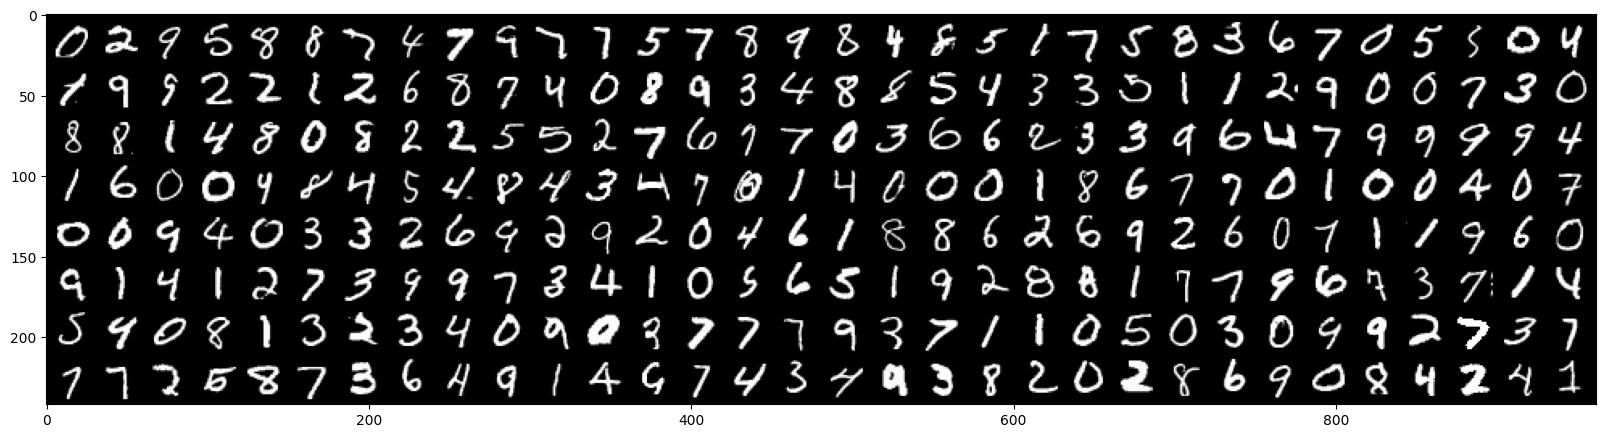

In [7]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images, 32)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Define our Neural Network Model 

### Multilayer perceptron: the math 
Here some of the math underlying the multilayer perceptron (MLP) and the backpropagation algorithm are reviewed. The MLP and backpropagation are central to understanding deep learning as a whole.

So what is a multilayer perceptron? Before we answer that question, let's dissect just a singular component: the perceptron. 

![perceptron](http://miro.medium.com/v2/resize:fit:1100/format:webp/1*n6sJ4yZQzwKL9wnF5wnVNg.png)

Image credit: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53

This image above represents schematically the conventional perceptron. Each input, represented as a multidimensional vector $\mathbf{x}=\{x_0=1,x_1,x_2,\ldots,x_n\}$, is multiplied by a set of weights $\mathbf{w} = \{w_0,w_1,w_2,\ldots,w_n\}$ to produce the weighted sum $$z = \sum_{i=0}^{n} x_i w_i$$. In the case of a vanilla perceptron, this weighted sum $z$ is lastly fed through as step function to produce the predicted output $a = \text{step}(z)$. This results in the output where $a=1$ if $z>0$ and $a=0$ if $z<0$.

With the output $a$ taking the value 0 or 1, this type of structure really only works for binary classification problems (i.e. situations where each input $\mathbf{x}$ has one of two intended labels: 0 or 1). The weights $\mathbf{w}$ in this context can be interpreted as assigning credence to the different inputs $x_i$ based on their relative importance. Notice, there is an additional constant $x_0=1$ concatenated to each input, frequently called the *bias term* or just *the bias*. As there is still an associated weight $w_0$ along with this term, this effectively acts as an offset to the origin for the classification. In other words, think of the perceptron classification boundary as a multidimensional line (or plane) $y = m * x + b$. Inputs on one side of the line where $y<0$ get classified as one label ($a=0$), while  inputs on the other side of the line where $y>0$ are classified as the other label ($a=1$). In this geometric interpretation of the perceptron, the weights are like the slope (or vector perpendicular to the plane in higher dimensions) $\mathbf{w} \sim m$, and the bias is like the $b$ term $b \sim w_0$.


Extending the perceptron to the multilayer perceptron (MLP) simply introduces a intermediate preceptrons (layers) before reading the output and generalizes the step function to a broader class of functions called *activation functions*. 

![MLP](http://camo.githubusercontent.com/8a0c06dc8a564e1e7732169d97e2685eafc2b98b5f4915f4c0cb6bf2c1649a37/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f717334746f6a763575356834386c662f6d756c74696c617965725f70657263657074726f6e2e706e673f7261773d31)

Image credit: https://github.com/PetarV-/TikZ/tree/master/Multilayer%20perceptron

These neural networks are often schematically represented with a series of nodes and arrows as shown on the right. Each node represents one input, for example the input layer here is shown with 3 inputs, and each arrow represents a *unique* weight given to that particular input in the weighted sum (right side of figure). Note, in our application to MNIST each input would be `784+1` dimensional (including the bias) and the output `10` dimensional for representing the one-hot encoded binary vector of output labels.

The additional layers between the inputs and outputs are typically called *hidden layers* because the particular value of the nodes within these layers are typically unknown, and largely uninterpretable, to the user. A natural question to ask here is why are hidden layers helpful/necessary for deep learning? The answer is, shockingly, that they aren't necessary, but are very helpful. There exists a theorem called the "Universal Approximation Theorem" which states basically that a neural network with a single layer can approximate *any* non-linear function to arbitrary accuracy. While this may imply that only a single hidden layer is, in principle, sufficient for any problem, the necessary dimension of this hidden layer may become intractably large for some problems. Introducing many hidden layers allows your neural network to learn a hierarchy of concepts in the structure of the data. What this implies for the MLP is that earlier layers (i.e. the layers closer to the input) learn a coarser representation of the data and begins to more closely reflect the output representation nearer to the output layer. 

![deep](http://miro.medium.com/v2/resize:fit:720/format:webp/1*ToPT8jnb5mtnikmiB42hpQ.png)

Image credit: https://srnghn.medium.com/deep-learning-overview-of-neurons-and-activation-functions-1d98286cf1e4

### Feed forward
Given a predefined neural network *architecture* (the *architecture* of a neural network refers to all the elements necessary to completely define the flow of data, which involve the number and size of hidden layers, which activation functions, the output size, etc.) the process of generating an output from an input is called a *forward* pass. As we shall see, for an MLP the forward pass may be succinctly represented as a series of matrix multiplications.

![MLP_big](http://neuralnetworksanddeeplearning.com/images/tikz12.png)

Image credit: http://neuralnetworksanddeeplearning.com/chap1.html

Consider the MLP represented schematically above with sigmoid activations $\sigma$ in the hidden layer. Each neuron in the hidden layers will be weighted sums of the inputs: $$a_j = \sigma(\sum_{i=1}^{784} x_i* w_{i,j})$$ for $j=\{1,2,\ldots,15\}$ (notice, there is no bias term in this example). From here it clear to see that the weights $w_{i,j}$ may be compacted into a matrix $W \in {\rm I\!R}^{784\times15}$ where $W_{i,j} = w_{i,j}$, allowing for all the neurons in the hidden layer to be efficiently calculated using matrix multiplication: $\mathbf{a}^{(1)} = \sigma(\mathbf{z}^{(1)}) = \sigma(\mathbf{x}W)$. Where $\mathbf{a}^{(i)},\mathbf{z}^{(i)} \in {\rm I\!R}^{1\times 15}$, with the superscript $(i)$ indicating the assocaited layer number, and $\mathbf{x} \in {\rm I\!R}^{1\times 784}$ are both arranged as column vectors. Another, different, weight matrix is needed to transform the hidden layer to the output layer. Let's demarcate these two as $W^{(1)}$ for the matrix which transforms the inputs to the hidden layer $\mathbf{a}^{(1)}$ and $W^{(2)} \in {\rm I\!R}^{15\times 10}$ for transforming the hidden layer to the output layer $\mathbf{z}^{(2)}$. Mathematically, $$\mathbf{z}^{(2)} = \sigma(\mathbf{x}W^{(1)})W^{(2)}$$ Notice, we've yet to treat this output $\mathbf{z}^{(2)}$ with an activation function.

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer $\mathbf{z}^{(2)}$. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.

The softmax activation function has the property of the outputs summing to 1 $\sum_{k=1}^{K=9}\text{softmax}(\mathbf{z}^{(2)})_k = 1$, allowing each output $\mathbf{a}^{(2)}_i = \text{softmax}(\mathbf{z}^{(2)})_i$ to be interpreted as the probability that the input is actually a digit `0-9`. Note, the output of a MLP does not need to have a softmax activation, for example in a regression setting a softmax activation would not make much sense. When evaluating the classification accuracy of the neural network, the input is typically classified according to the output label with the highest probability, $$\text{prediction}(\mathbf{x}) = \text{argmax}\  \text{softmax}(\mathbf{z}^{(2)}) = \text{argmax}\  \text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$$\.

### Backpropagation
Now that we have an understanding of how an MLP generates outputs from inputs, we engage the problem of how to actually *train* this neural network. *Training* a neural network (in a supervised setting, which means each input comes with a known output) refers to the process of iteratively updating the weights of the network to improve it's performance. The performance of the neural network is evaluated using a *loss function* which quantitatively measures how "close" the neural network output is to the true output. In short, using *backpropagation* we aim to minimize the loss function with respect to the weights (also called *parameters*) of the neural network.     

First, let's define precisely what we mean by a *cost function*. The cost function $C$ should reflect whatever objective your aim is for the neural network. Here, we're interested in having our neural network predict a digit label `0-9` for each input image. A natural, and very reasonable, choice in many settings is simply using the L2 norm between our predicted and true outputs $$C = \frac{1}{2N}\sum_{i=1}^N||y_i - \mathbf{a}^{(L)}(\mathbf{x}_i)||^2$$, where $y_i$ represents the true label corresponding to input $\mathbf{x}_i$ and $\mathbf{a}^{(L)}(\mathbf{x}_i)$ is the output of the neural network with $L$ layers taking $\mathbf{x}_i$ as input. Note, in our previous example $\mathbf{a}^{(L=2)}(\mathbf{x}_i) = \text{softmax}((\sigma(\mathbf{x}_iW^{(1)})W^{(2)}))$. Of course, when minimizing/maximizing a function any constant multiplies have no effect on the optimum which allows us to include the $\frac{1}{2N}$ as a mathematical convenience whose purpose will be clear shortly (spoiler, it has to do with derivatives). We may equivalently write this cost function in terms of the cost incurred by each sample individually as $$C = \frac{1}{N}\sum_{i=1}^N C_i$$. Where the cost of an individual training sample is of course, in the case of our quadratic cost function, $C_i = \frac{1}{2}||y_i - \mathbf{a}^{(L)}(\mathbf{x}_i)||^2$.

Ultimately, training our neural network by incrementally adjusting the weights amounts to updating each weight $W^{(l)}_{i,j}$ based on its individual influence to the cost function. This can be done with the *gradient descent* algorithm that defines the update rule $$W^{(l)}_{i,j} \leftarrow W^{(l)}_{i,j} - \alpha \frac{\partial C}{\partial W^{(l)}_{i,j}}$$, where $\alpha$ is a tunable parameter called the *learning rate*. Notice, vanilla gradient descent requires computing the derivative (people in the ML community use the word gradient, rather than derivative) $\frac{\partial C}{\partial W^{(l)}_{i,j}}$ with respect to **all** the training samples. Of course, this can become expensive very quickly as some datasets, for example, contain millions of image and it's simply intractable for computational reasons to work with all that data at once. Therefore, people typically (read, always) employ a modified version of gradient descent called *stochastic gradient descent* (SGD) which updates the weights in *batches* (also called *mini batches*) of size $m$ $$W^{(l)}_{i,j} \leftarrow W^{(l)}_{i,j} - \frac{\alpha}{m}\sum_{k \in \text{batch}} \frac{\partial C_k}{\partial W^{(l)}_{i,j}}$$. Where $C_i$ is the previously discussed cost function for an individual training sample $i$.

In order to actually perform SGD we are left with the task of evaluating the gradient $\frac{\partial C_i}{\partial W^{(l)}_{i,j}}$. However, we must be able to evaluate this gradient quickly and ideally in parallel as this calculation will be performed many, many times. This, finally, is where the *backpropagation* algorithm comes into play. 

Let's define the quantity $$\delta^{(l)}_j = \frac{\partial C}{\partial z^{(l)}_j}$$.

Recalling that each hidden layer is expressed as $a^{(l)}_i = \sigma(z^{(l)}_i) = \sigma(\sum_j W^{(l)}_{i,j} * a^{(l-1)}_j)$. Note, for simplicity I've omitted the bias term from $z$, and am using $\partial C$ rather than $\partial C_i$ for notational convenience. This $\delta^{(l)}_j$ term may be thought of as the output error for neuron $j$ in layer $l$ with respect to the cost function $C$. Using $\delta^{(l)}_j$ we can get at our sought after gradient by applying the chain rule $$\frac{\partial C_i}{\partial W^{(l)}_{i,j}} = \frac{\partial C}{\partial z^{(l)}_i} \frac{\partial z^{(l)}_i}{\partial W^{(l)}_{i,j}} = \delta^{(l)}_i * a^{(l-1)}_j$$. Where $\frac{\partial z^{(l)}_j}{\partial W^{(l)}_{i,j}} = a^{(l-1)}$ can be readily derived recalling that $z^{(l)}_i = \sum_k W^{(l)}_{i,k} * a^{(l-1)}_k$.

Excellent! Now we have a closed-form analytical expression for $\frac{\partial C_i}{\partial W_{i,j}}$. But how do we actually compute $\delta^{(l)}_j$ in this expression? Let's start with the last layer $L$ and apply the chain rule again, $$\delta^{(L)}_j = \frac{\partial C}{\partial a^{(L)}_j} \frac{\partial a^{(L)}_j}{\partial z^{(L)}_j} = \frac{\partial C}{\partial a^{(L)}_j} \sigma^{\prime}(z^{(L)}_j)$$. The first term $\frac{\partial C}{\partial a^{(L)}_j}$ is simply the error in the cost function with respect to the last layer, a quantity which can frequently be directly derived. For instance, in the case of the quadratic cost function $C = \frac{1}{2}||y - a^{(L)}_{j}||^2$, the derivative is simply $\frac{\partial C}{\partial a^{(L)}_j} = (a^{(L)}_j - y)$. Next, the $\sigma^{\prime}(z^{(L)}_j)$ is nothing more than the derivative of the activation function at numerical value of $z^{(L)}_j$. This is where the previously mentioned mathematical convenience of select activation functions comes in, say, for the sigmoid activation: $\sigma^{\prime}(x) = \sigma(x) (1-\sigma(x))$. What this means is that once we have computed $\sigma(z^{(l)}_j)$ (for any $l$) during the forward pass of the network, we can store and reuse that value to efficiently compute $\sigma^{\prime}(z^{(l)}_j)$ during backpropagation!

Okay, this is the last step. With the error in the last layer $\delta^{(L)}_j$ computed the final piece of the puzzle is computing the error for the remaining layers $\delta^{(l)}_j$. Here, I will simply state the formula for the sake of brevity -- but I encourage you to look at the proof available [here](http://neuralnetworksanddeeplearning.com/chap2.html), or even better, try to prove it yourself! 

$$\boldsymbol{\delta}^{l}=((W^{(l+1)})^{T} \boldsymbol{\delta}^{l+1}) \odot \sigma^{\prime}(\mathbf{z}^{l})$$ 

The only new notation introduced here is the *hadamard product* $\odot$: which simply performs an element-wise multiplication along two vectors (e.g. $(\mathbf{x} \odot \mathbf{y})_i = x_i * y_i$). Looking at this equation, we realize now why backpropagation is called *backpropagation*: the errors for a given layer $\boldsymbol{\delta}^{l}$ depend on the errors in the following layer $\boldsymbol{\delta}^{l+1}$. Thus, once we have computed the error in the last layer $\boldsymbol{\delta}^{L}$, backpropagation effectively works backward to compute the errors in the remaining layers which are then purposed to calcaulte the gradients $\frac{\partial C_i}{\partial W^{(l)}_{i,j}}$ used to update the weights $W^{(l)}_{i,j}$ in SGD. That's it. That's the math which drives how neural networks *actually* learn.

In [8]:
# Lets create a simple MLP network similar to the sine wave approximator
class Simple_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Simple_MLP, self).__init__()
        # We will use 4 linear layers
        # The input to the model is 784 (28x28 - the image size)
        # and the should be num_classes outputs
        self.all_layers = torch.nn.Sequential(
            # TO DO-  hidded layer size 512
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            # TO DO-  hidded layer size 256
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            # TO DO-  hidded layer size 128
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            # TO DO-  output layer size num_classes
            torch.nn.Linear(128, num_classes),
            torch.nn.ReLU(),
        )
        

    def forward(self, x):
        
        # The data we pass the model is a batch of single channel images
        # with shape BSx1x28x28 we need to flatten it to BSx784
        # To use it in a linear layer
        x = x.view(x.shape[0], -1)

        #-------------------------------------------------------------------------------------------------------------------------
        # Activation Function will be discussed in class. Stay tuned for more details and prepare to engage with the new material!
        #-------------------------------------------------------------------------------------------------------------------------
        # We will use a relu activation function for this network! (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
    
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.all_layers(x)
        x.to(device)
        return x # TO DO

<h3> Create the model and define the Loss and Optimizer</h3>
Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using Cross Entropy Loss 

[torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

[Killer Combo: Softmax and Cross Entropy by Paolo Perrotta
](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba)

Just like in the sine wave approximation, experiment with different optimizers and hyperparameters 

In [9]:
# Create our model
model = nn.Sequential(
    Simple_MLP(num_classes=10)
    ).to(device) # TO DO create a model with 10 classes

#Create our loss function
criterion = nn.CrossEntropyLoss() # TO DO add the Cross Entropy loss Function
#Define our loss funcition and optimizer
lr = .001 # TO DO
optimizer = optim.Adam(model.parameters(), lr=lr)# TO DO
# Number of Epochs
n_epochs = 25 # TO DO

# We can print out our model structure
print(model)
# Note: this is only the order in which the layers were defined NOT the path of the forward pass!

Sequential(
  (0): Simple_MLP(
    (all_layers): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=10, bias=True)
      (7): ReLU()
    )
  )
)


<h3> Create a function that will train the network for one epoch </h3>

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training", leave=False)):   
        
        # Forward pass of model
        outputs = model(data.to(device)) # TO DO
#         print(sum(outputs))

        # Calculate loss
        loss = criterion(outputs, target.to(device)) # TO DO
        
        # Zero gradients
        # TO DO
        optimizer.zero_grad()
        
        # Backprop loss
        # TO DO
        loss.backward()
        
        
        # Optimization Step
        # TO DO
        optimizer.step()
        
        
    loss_logger.append(loss.item())

    return model, optimizer, loss_logger

<h3> Create a function that will evaluate our network's performance on the test set </h3>

In [11]:
def test_model(model, test_loader, criterion, loss_logger):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):   
            
            # Forward pass of model
            outputs = model(data.to(device)) # TO DO           
            
            # Calculate the accuracy of the model
            # You'll need to accumulate the accuracy over multiple steps
            
            # TO DO
            # Number of correctly predicted outputs
            _, predicted = torch.max(outputs.data, 1)
            
            correct_predictions += (predicted == target.to(device)).sum().item()# TO DO
            # Total number of predictions made
            total_predictions += labels.size(0)# TO DO
            
            # Calculate the loss
             # TO DO
        loss = criterion(outputs.to(device), target.to(device))  # Compute the loss using the criterion (cross-entropy or other)
        loss_logger.append(loss.item())
            
        acc = (correct_predictions/total_predictions) * 100.0
        return loss_logger, acc

## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [12]:
# moved down

In [26]:
# Create empty lists for the train/test losses and the test accuracy
train_loss = []
test_loss  = []
test_acc   = []


for i in trange(n_epochs, desc="Epoch", leave=False):
    # Call the trainging function to perform an epoch of training
    model, optimizer, train_loss = train_epoch(model, train_loader, criterion, optimizer, train_loss) # TO DO
    
    # Call the testing function to work out the test loss and accuracy!
    test_loss, acc = test_model(model, test_loader, criterion, test_loss) # TO DO
    test_acc.append(acc)

print("Final Accuracy: %.2f%%" % acc)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Final Accuracy: 67.69%


## Visualize Training Data

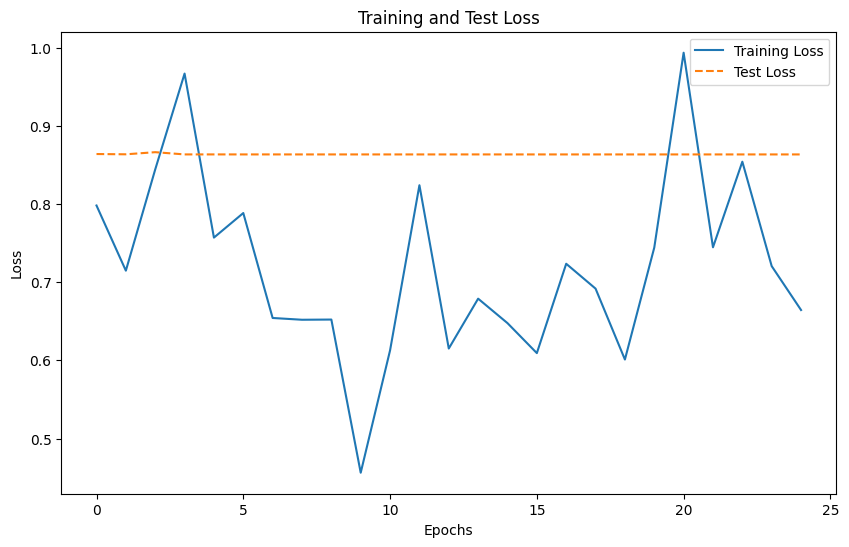

In [27]:
# Plot the Training and Test losses
# TO DO
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(test_loss, label="Test Loss", linestyle='--')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    plt.show()
    
plot_losses(train_loss, test_loss)


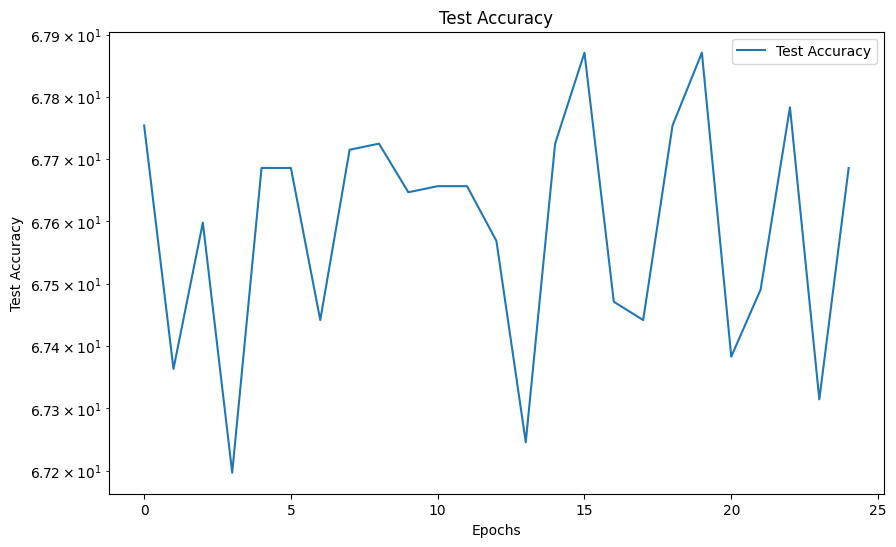

In [28]:
# Plot the Test Accuracy
# TO DO
def plot_acc(test_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(test_acc, label="Test Accuracy")
   
    plt.yscale('log') # Set y-axis to logarithmic scale

    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy")
    plt.legend()

    plt.show()
    
plot_acc(test_acc)